# Analytic disk

We create a Magritte model from an analytic description of a Keplerian disk (see e.g. [Homan et al. 2018](https://doi.org/10.1051/0004-6361/201732246); [Booth et al. 2019](https://doi.org/10.1051/0004-6361/201834388)).

## Setup

Import the required functionalty.

In [1]:
import magritte.setup    as setup                   # Model setup
import magritte.core     as magritte                # Core functionality
import magritte.mesher   as mesher                  # Mesher
import numpy             as np                      # Data structures
import meshio
import warnings                                     # Hide warnings
warnings.filterwarnings('ignore')                   # especially for yt
import yt                                           # 3D plotting
import os

from tqdm                import tqdm                # Progress bars
from astropy             import units, constants    # Unit conversions
from scipy.spatial       import Delaunay, cKDTree   # Finding neighbors
from yt.funcs            import mylog               # To avoid yt output 
mylog.setLevel(40)                                  # as error messages

Define a working directory (you will have to change this; it must be an **absolute path**).

In [2]:
wdir = "/lhome/thomasc/Magritte-examples/Analytic_disk/"

Create the working directory.

In [3]:
!mkdir -p $wdir

Define file names.

In [4]:
model_file = os.path.join(wdir, 'model_analytic_disk.hdf5')   # Resulting Magritte model
lamda_file = os.path.join(wdir, 'co.txt'                  )   # Line data file
bmesh_name = os.path.join(wdir, 'analytic_disk'           )   # bachground mesh name (no extension!)

We use a data file that can be downloaded with the following links.

In [5]:
lamda_link = "https://home.strw.leidenuniv.nl/~moldata/datafiles/co.dat"

Dowload the snapshot and the linedata (``%%capture`` is just used to suppress the output).

In [6]:
%%capture
!wget $lamda_link --output-document $lamda_file

## Model parameters

The functions below describe the disk structure, based on the Magritte application presented in [De Ceuster et al. (2019)](https://doi.org/10.1093/mnras/stz3557).

In [7]:
G      =           constants.G.si.value
kb     =           constants.k_B.si.value
m_H2   = 2.01588 * constants.u.si.value

XCO    =  6.0e-4   # [.]
vturb  =  1.5e+3   # [m/s]

M_star =     2.0 * constants.M_sun.si.value
r_star =     2.0 * constants.au.si.value
T_star =    2500   # [K]

rho_in = 5.0e-12   # [kg/m^3]
r_out  =   600.0 * constants.au.si.value
r_in   =    10.0 * constants.au.si.value
T_in   =    1500   # [L]

p      =  -2.125   # [.]
h      =   1.125   # [.]
q      =  -0.5     # [.]


def cylindrical(x, y, z):
    """
    Convert cartesian to cylindrical coordinates.
    """
    rxy = np.sqrt   (x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rxy, phi, z)


def H(rxy):
    """
    Vertical Gaussian scale height.
    """
    # Compute prefactor
    prefactor = r_in * np.sqrt(kb * T_in / m_H2 * r_in / (G * M_star))
    # Return power law result
    return prefactor * np.power(rxy/r_in, h)


def density(rr):
    """
    Keplerian disk density in cylindrical coordinates.
    """
    # Convert carthesian to cylindrical coords
    (rxy,phi,z) = cylindrical(rr[0],rr[1],rr[2])
    # Compute density
    rho = rho_in * np.power(rxy/r_in, p) * np.exp(-0.5 * (z/H(rxy))**2)
    # Set radii below r_in to zero (in a way that also work for np arrays)
    if hasattr(rxy, "__len__"):
        rho[rxy<r_in] = 0.0
    else:
        if (rxy<r_in):
            rho = 0.0
    # Return result
    return rho


def abn_nH2(rr):
    """
    H2 number density function.
    """
    return density(rr) / (2.01588 * constants.u.si.value)


def abn_nCO(rr):
    """
    CO number density function.
    """
    return XCO * abn_nH2(rr)


def temperature(rr):
    """
    Temperature structure.
    """
    # Convert carthesian to cylindrical coords
    (rxy,phi,z) = cylindrical(rr[0],rr[1],rr[2])
    # Get spherical radial coordinate
    r = np.sqrt(rxy**2 + z**2)
    # Compute temperature
    return T_star * np.power(r/r_star, q)
    
        
def turbulence(rr):
    """
    !!! Peculiar Magritte thing...
    Square turbulent speed as fraction of the speed of light.
    """
    return (vturb/constants.c.si.value)**2

    
def velocity_f(rr):
    """
    Velocity structure.
    """
    # Convert carthesian to cylindrical coords
    (rxy,phi,z) = cylindrical(rr[0],rr[1],rr[2])
    # Get spherical radial coordinate
    r = np.sqrt(rxy**2 + z**2)
    # Compute angle
    d = phi + 0.5 * np.pi
    # Compute velocity (in carthesian )
    return np.sqrt(G * M_star/r) * np.array([np.cos(d), np.sin(d), 0.0]) / constants.c.si.value

## Create background mesh

Define the desired background mesh, a ($75 \times 75 \times 75$) cube.

In [8]:
resolution = 75

xs = np.linspace(-r_out, +r_out, resolution, endpoint=True)
ys = np.linspace(-r_out, +r_out, resolution, endpoint=True)
zs = np.linspace(-r_out, +r_out, resolution, endpoint=True)

(Xs, Ys, Zs) = np.meshgrid(xs, ys, zs)

# Extract positions of points in background mesh
position = np.array((Xs.ravel(), Ys.ravel(), Zs.ravel())).T

# Evaluate the density on the cube
rhos      = density([Xs, Ys, Zs])
rhos_min  = np.min(rhos[rhos!=0.0])
rhos     += rhos_min

Now we remesh this model using the new remesher

In [9]:
positions_reduced, nb_boundary = mesher.remesh_point_cloud(position, rhos.ravel(), max_depth=10, threshold= 2e-1, hullorder=4)

new interior points:  198688
number boundary points:  1538


We add a spherical inner boundary at 0.01*r_out

In [10]:
healpy_order = 5 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T #the origin of the inner boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_inner_boundary(positions_reduced, nb_boundary, 0.01*r_out, healpy_order=healpy_order, origin=origin)
print("number of points in reduced grid: ", len(positions_reduced))
print("number of boundary points: ", nb_boundary)

number of points in reduced grid:  200525
number of boundary points:  1838


We add a spherical outer boundary at r_out

In [11]:
healpy_order = 15 #using healpy to determine where to place the 12*healpy_order**2 boundary points on the sphere
origin = np.array([0.0,0.0,0.0]).T #the origin of the inner boundary sphere
positions_reduced, nb_boundary = mesher.point_cloud_add_spherical_outer_boundary(positions_reduced, nb_boundary, r_out, healpy_order=healpy_order, origin=origin)
print("number of points in reduced grid: ", len(positions_reduced))

number of points in reduced grid:  114051


In [12]:
npoints = len(positions_reduced)

# Extract Delaunay vertices (= Voronoi neighbors)
delaunay = Delaunay(positions_reduced)
(indptr, indices) = delaunay.vertex_neighbor_vertices
neighbors = [indices[indptr[k]:indptr[k+1]] for k in range(npoints)]
nbs       = [n for sublist in neighbors for n in sublist]
n_nbs     = [len(sublist) for sublist in neighbors]

# Convenience arrays
zeros = np.zeros(npoints)
ones  = np.ones (npoints)

Convert model functions to arrays based the model mesh.

In [13]:
position = positions_reduced
velocity = np.array([velocity_f (rr) for rr in positions_reduced])
nH2      = np.array([abn_nH2    (rr) for rr in positions_reduced])
nCO      = np.array([abn_nCO    (rr) for rr in positions_reduced])
tmp      = np.array([temperature(rr) for rr in positions_reduced])
trb      = np.array([turbulence (rr) for rr in positions_reduced])

## Create model

Now all data is read, we can use it to construct a Magritte model.

<div class="alert alert-warning">

Warning

Since we do not aim to do self-consistent non-LTE simulations in these examples, we only consider the first radiative transition of CO (J=1-0). To consider all transitions, use `setup.set_linedata_from_LAMDA_file` as in the commented line below it.
We also only consider 2 rays here (up and down the direction we want to image). To consider all directions, comment out the indecated lines and use `setup.set_uniform_rays` as in the commented line below.
    
</div>

In [14]:
model = magritte.Model ()                              # Create model object

model.parameters.set_model_name         (model_file)   # Magritte model file
model.parameters.set_dimension          (3)            # This is a 3D model
model.parameters.set_npoints            (npoints)      # Number of points
model.parameters.set_nrays              (2)            # Number of rays  
model.parameters.set_nspecs             (3)            # Number of species (min. 5)
model.parameters.set_nlspecs            (1)            # Number of line species
model.parameters.set_nquads             (51)           # Number of quadrature points

model.geometry.points.position.set(position)
model.geometry.points.velocity.set(velocity)

model.geometry.points.  neighbors.set(  nbs)
model.geometry.points.n_neighbors.set(n_nbs)

model.chemistry.species.abundance = np.array((nCO, nH2, zeros)).T
model.chemistry.species.symbol    = ['CO', 'H2', 'e-']

model.thermodynamics.temperature.gas  .set(tmp)
model.thermodynamics.turbulence.vturb2.set(trb)

model.parameters.set_nboundary(nb_boundary)
model.geometry.boundary.boundary2point.set(np.arange(nb_boundary))

direction = np.array([[+1,0,0], [-1,0,0]])            # Comment out to use all directions
model.geometry.rays.direction.set(direction)          # Comment out to use all directions
model.geometry.rays.weight   .set(0.5 * np.ones(2))   # Comment out to use all directions

# setup.set_uniform_rays            (model)   # Uncomment to use all directions
setup.set_boundary_condition_CMB  (model)
setup.set_linedata_from_LAMDA_file(model, lamda_file, {'considered transitions': [0]})
# setup.set_linedata_from_LAMDA_file(model, lamda_file)   # Consider all transitions
setup.set_quadrature              (model)

model.write()

Not considering all radiative transitions on the data file but only the specified ones!
Writing parameters...
Writing points...
Writing rays...
Writing boundary...
Writing chemistry...
Writing species...
Writing thermodynamics...
Writing temperature...
Writing turbulence...
Writing lines...
Writing lineProducingSpecies...
Writing linedata...
ncolpoar = 2
--- colpoar = 0
Writing collisionPartner...
(l, c) = 0, 0
--- colpoar = 1
Writing collisionPartner...
(l, c) = 0, 1
Writing quadrature...
Writing populations...
Writing radiation...
Writing frequencies...


## Plot model

Load the data in a `yt` unstructured mesh.

In [15]:
ds = yt.load_unstructured_mesh(
    connectivity = delaunay.simplices.astype(np.int64),
    coordinates  = delaunay.points.astype(np.float64) * 100.0, # yt expects cm not m 
    node_data    = {('connect1', 'n'): nCO[delaunay.simplices].astype(np.float64)}
)

Plot a slice through the mesh orthogonal to the z-axis and x-axis.


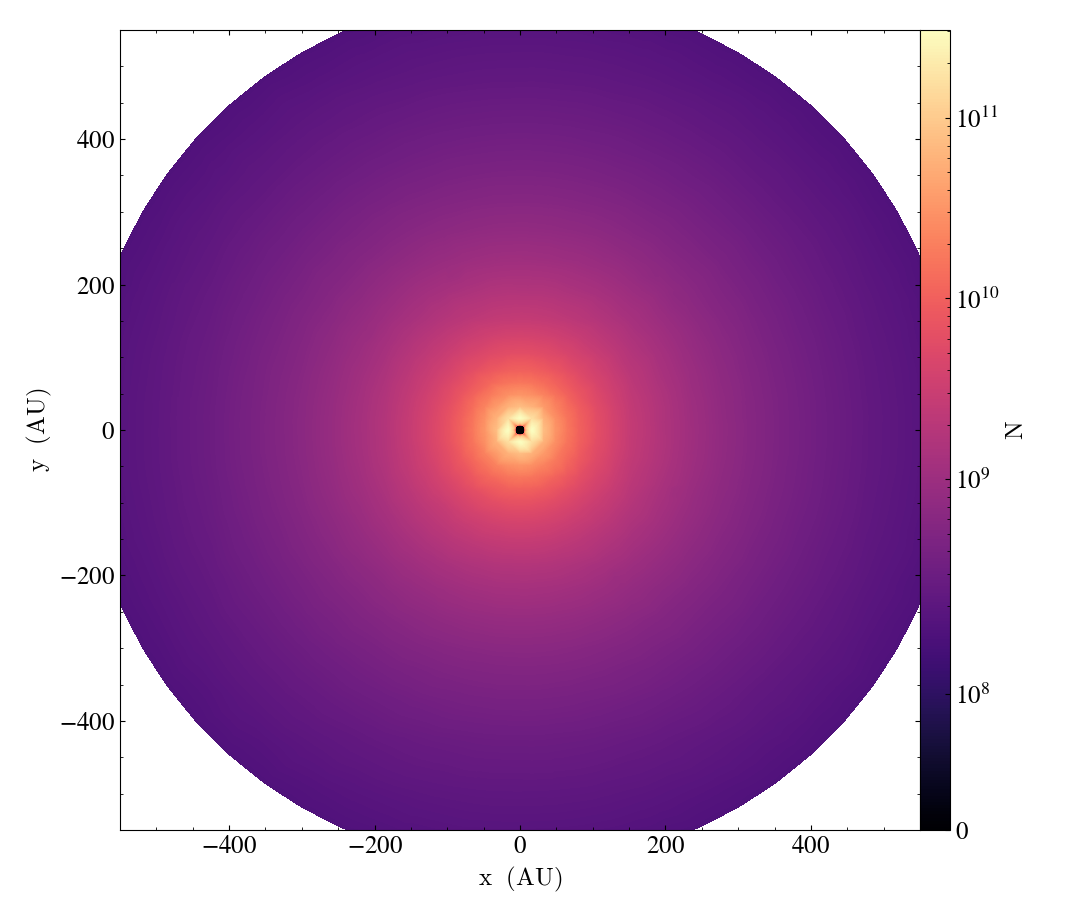

In [16]:
sl = yt.SlicePlot (ds, 'z', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)


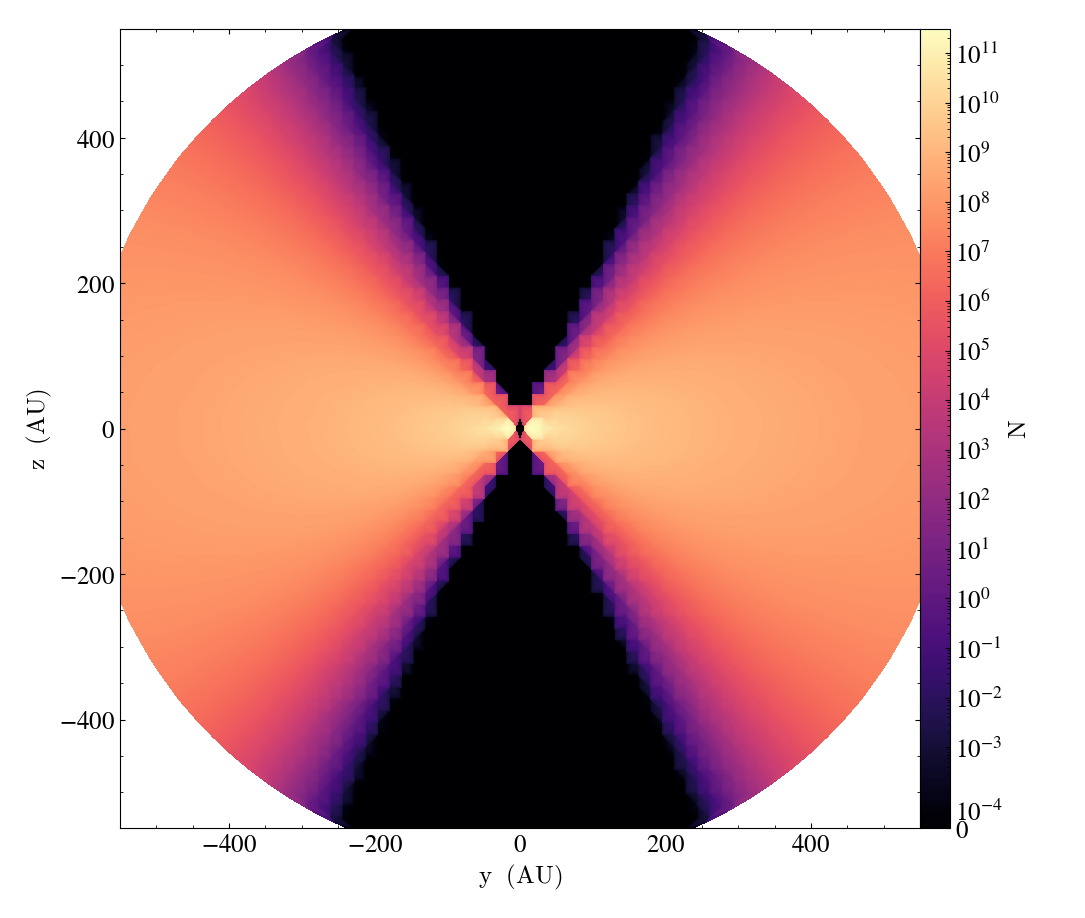

In [17]:
sl = yt.SlicePlot (ds, 'x', ('connect1', 'n'))
sl.set_cmap       (('connect1', 'n'), 'magma')
sl.zoom           (1.2)

Show meshes on the plots.


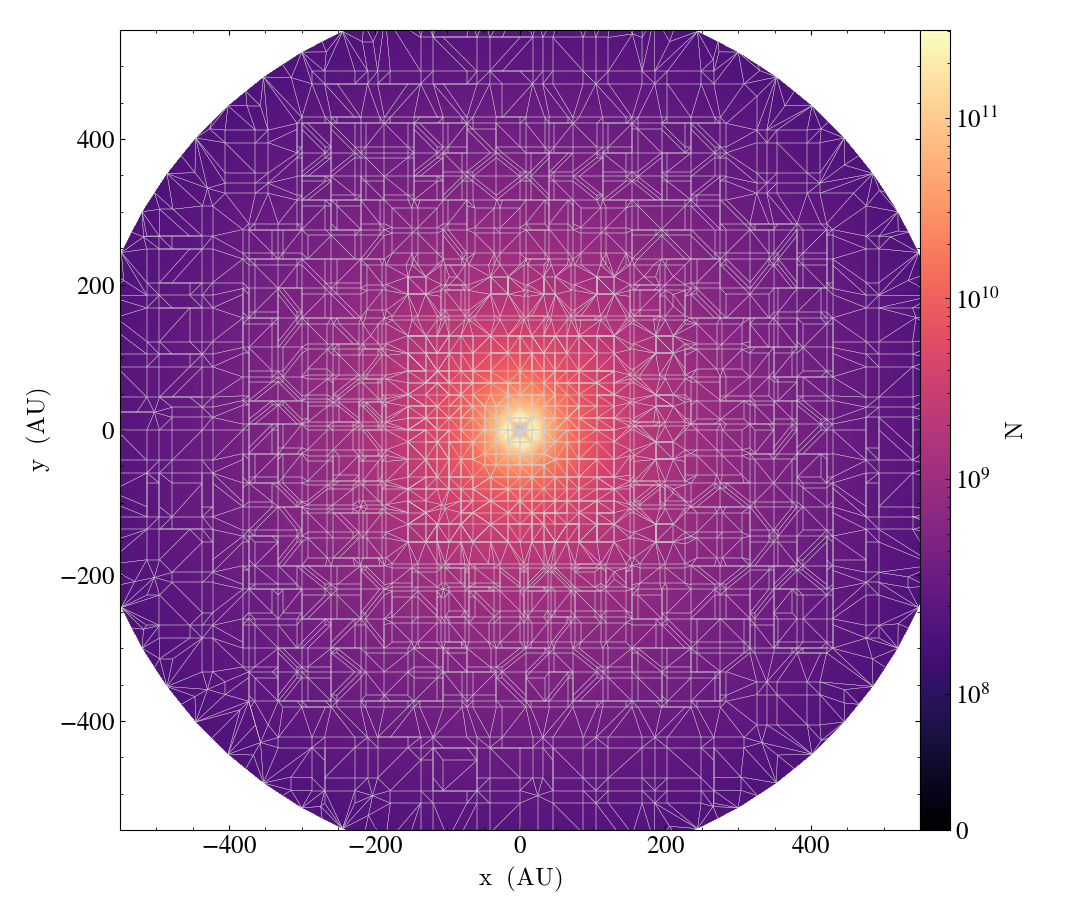

In [18]:
sl = yt.SlicePlot      (ds, 'z', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})


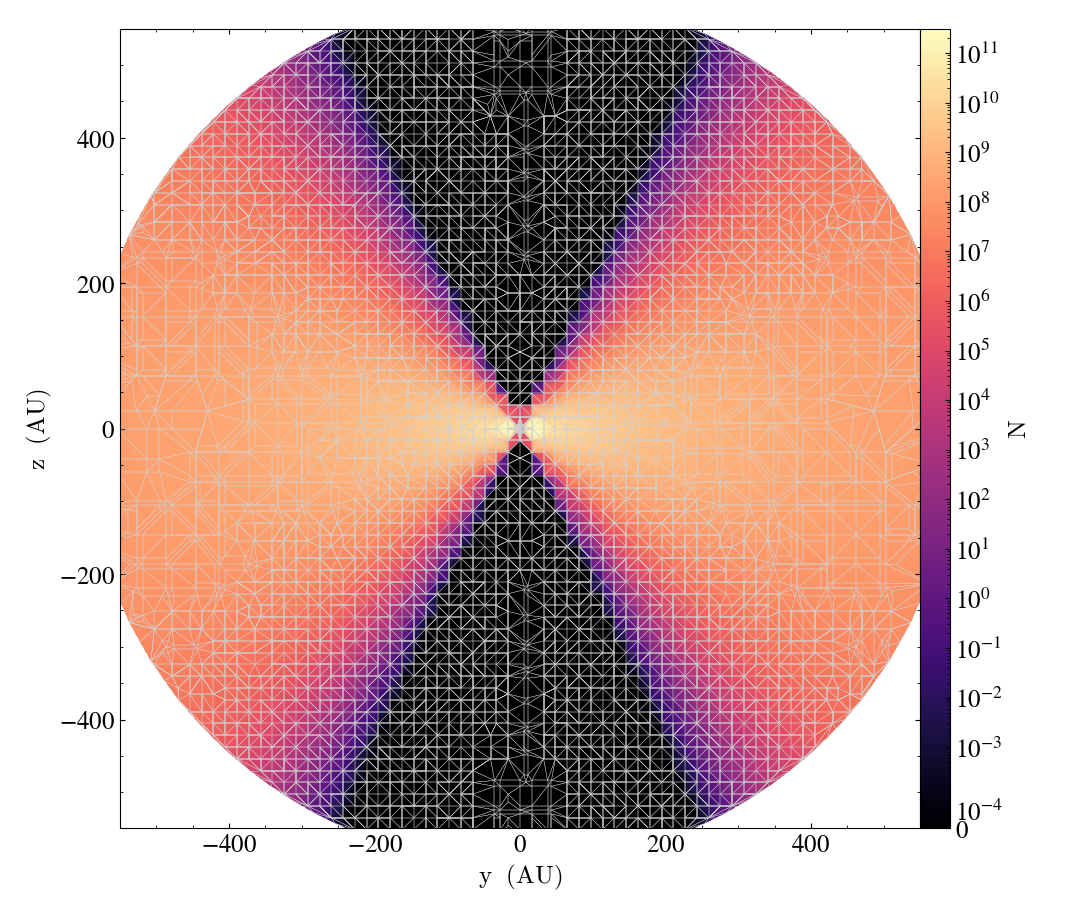

In [19]:
sl = yt.SlicePlot      (ds, 'x', ('connect1', 'n'))
sl.set_cmap            (('connect1', 'n'), 'magma')
sl.zoom                (1.2)
sl.annotate_mesh_lines (plot_args={'color':'lightgrey', 'linewidths':[.25]})